# Santander Customer Transaction Prediction from Kaggle

## We are given a train and test dataset from a company that specializes in creating products that aid customer's financial health. We are asked to predict the specific transaction a customer will make in the future.

### Task - predict the value of target column in the test set.

1. [Packages and Data Prep](#Packages-and-Data-Prep)
2. [Analyze and tweak data](#Analyze-and-tweak-data)
3. [EDA](#EDA)
4. [Prepare for modeling](#Prepare-for-modeling)
5. [Model building](#Model-building)
6. [Final model build](#Final-model-build)
7. [Submit work](#Submit-work)

### Packages and Data Prep

In [2]:
# data analysis
import pandas as pd
import numpy as np
import random as rnd
import math
from scipy import stats
from scipy.stats import norm, skew, mode
from scipy.special import boxcox1p

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
%matplotlib inline

# machine learning
from joblib import parallel_backend
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
combined = [traindf, testdf]

In [4]:
traindf.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
testdf.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


This is what our submission should look like:

In [6]:
sample.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [7]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [8]:
traindf, NAlist = reduce_mem_usage(traindf)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276611328125  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_144
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_145
dtype before:  float64
dtype af

In [9]:
testdf, NAlist = reduce_mem_usage(testdf)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017822265625  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_75
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_76
dtype before:  float64
dtype after:  fl

Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_144
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_145
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_146
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_147
dtype before:  float64
dtype after:  float32
******************************
******************************
Column: 

In [10]:
traindf.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


In [11]:
testdf.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.267500,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.711200,2.4669,4.3654,10.7200,15.472200,-8.719700
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.631599,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.576500,0.4773,-1.4852,9.8714,19.129299,-20.976000
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.253700,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.981300,2.1281,-7.1086,7.0618,19.895599,-23.179399
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.566000,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.187400,3.1656,3.9567,9.2295,13.016800,-4.210800
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.604800,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.554199,-0.2860,-5.1612,7.2882,13.926000,-9.184600


## Analyze and tweak data

In [12]:
traindf.info()
print('_'*60)
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
____________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float32(200), object(1)
memory usage: 154.1+ MB


In [13]:
traindf.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715190,6.796530,11.078333,-5.065317,5.408949,16.545851,0.284162,...,3.234439,7.438409,1.927838,3.331773,17.993788,-0.142088,2.303335,8.908157,15.870723,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863266,0.866607,3.418076,3.332633,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010946,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562599,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852798
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064724,4.836800
max,1.000000,20.315001,10.376800,19.353001,13.188300,16.671400,17.251600,8.447700,27.691799,10.151300,...,18.440901,16.716499,8.402400,18.281799,27.928801,4.272900,18.321501,12.000400,26.079100,28.500700


In [14]:
testdf.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707451,6.788214,11.076399,-5.050557,5.415163,16.529144,0.277135,7.569407,...,3.189766,7.458268,1.925944,3.322016,17.996969,-0.133657,2.290899,8.912429,15.869184,-3.246341
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231866,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446345,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457802
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391726,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292801,9.665500,11.003600,...,20.358999,16.716499,8.005000,17.632601,27.947800,4.545400,15.920700,12.275800,26.538401,27.907400


Quick description of the variables.

In [15]:
y_train = traindf.target.values

In [16]:
traindf['target'].unique()

array([0, 1], dtype=uint8)

Results should be binary. 0 means no transaction was made. 1 means a transaction was made.

In [17]:
print(traindf.shape, testdf.shape)

(200000, 202) (200000, 201)


Both datasets have 200,000 inputs.

In [18]:
t = traindf.isnull().sum()
p = (traindf.isnull().sum()/traindf.isnull().count()).sort_values(ascending=False)
d = traindf.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head()


t = testdf.isnull().sum()
p = (testdf.isnull().sum()/testdf.isnull().count()).sort_values(ascending=False)
d = testdf.dtypes
missing_table2 = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head()

,Total,Percent,Dtypes
ID_code,0,0.0,object
target,0,0.0,uint8
var_0,0,0.0,float32
var_1,0,0.0,float32
var_2,0,0.0,float32


In [19]:
missing_table2.head()

,Total,Percent,Dtypes
ID_code,0,0.0,object
var_0,0,0.0,float32
var_1,0,0.0,float32
var_2,0,0.0,float32
var_3,0,0.0,float32


Good news! No missing values, now we move to exploratory data analysis.

## EDA

##### Correlation to the target

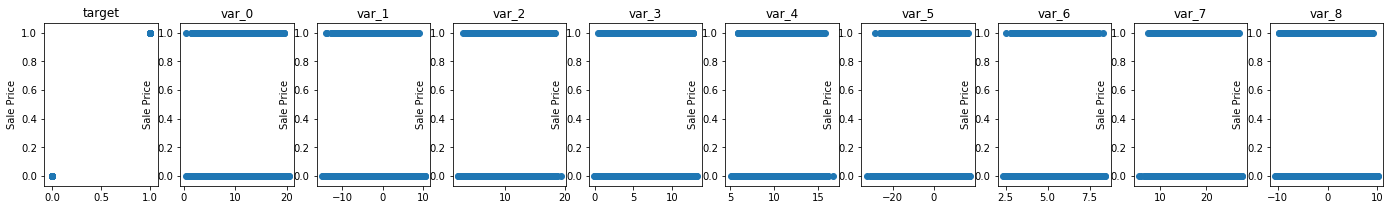

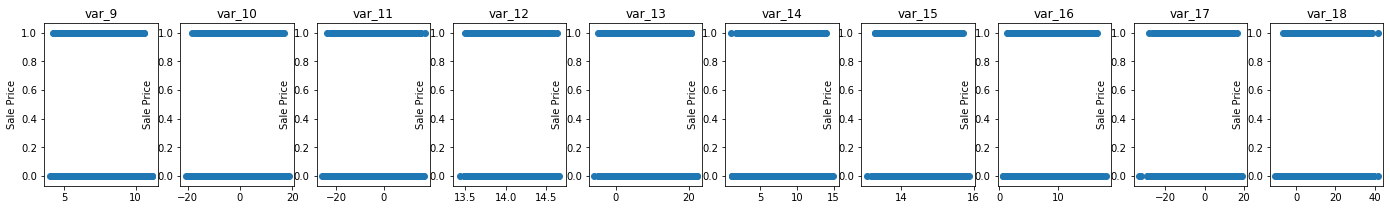

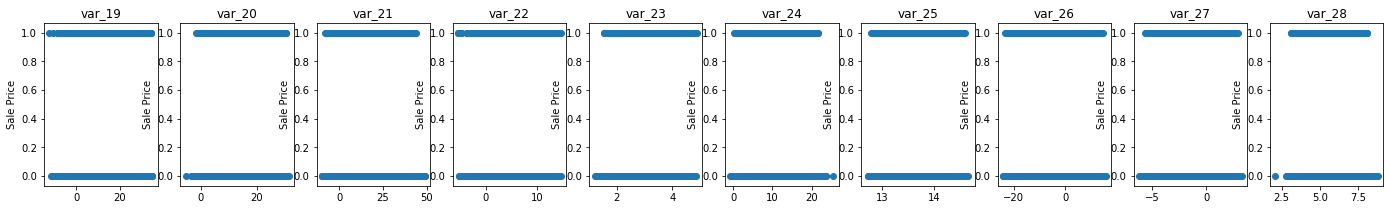

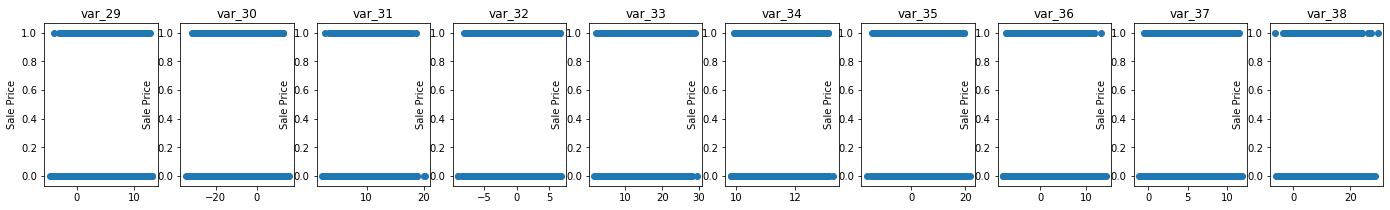

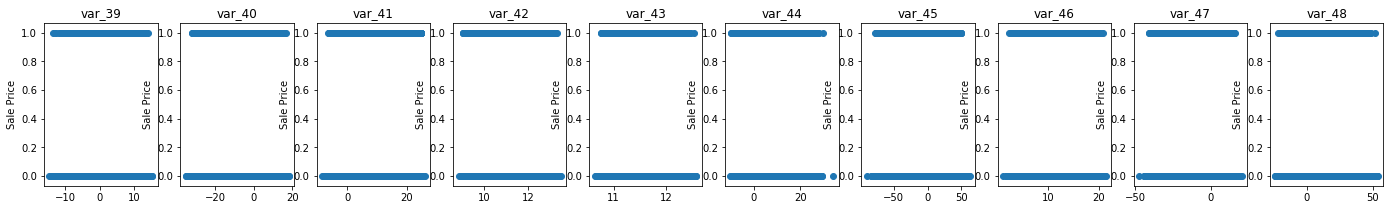

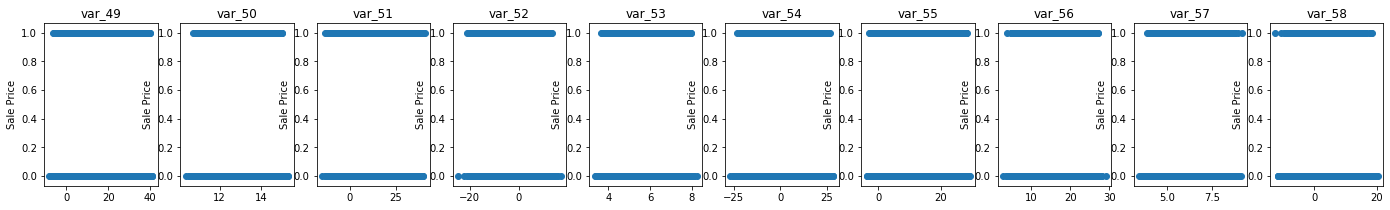

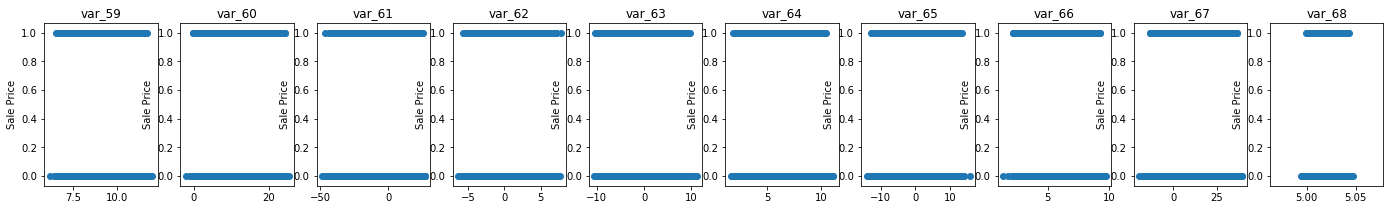

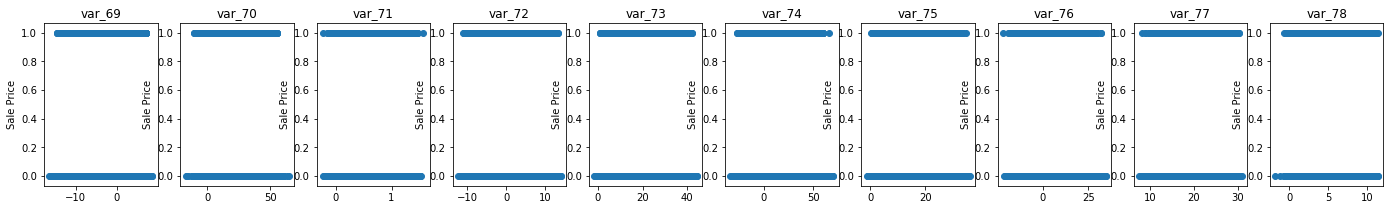

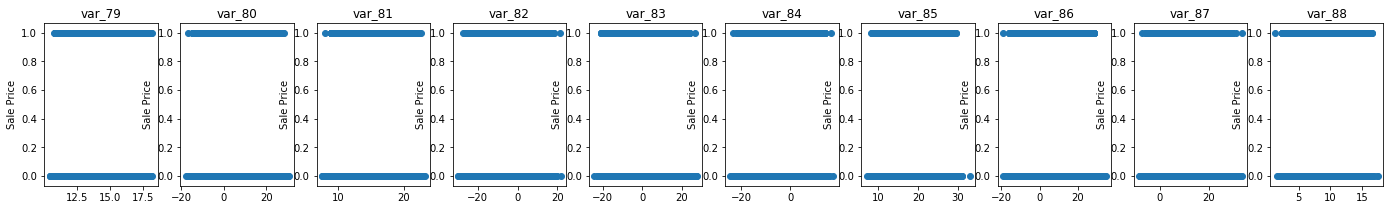

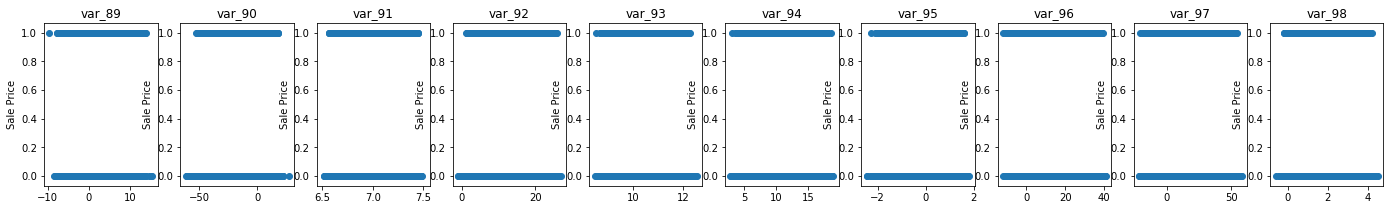

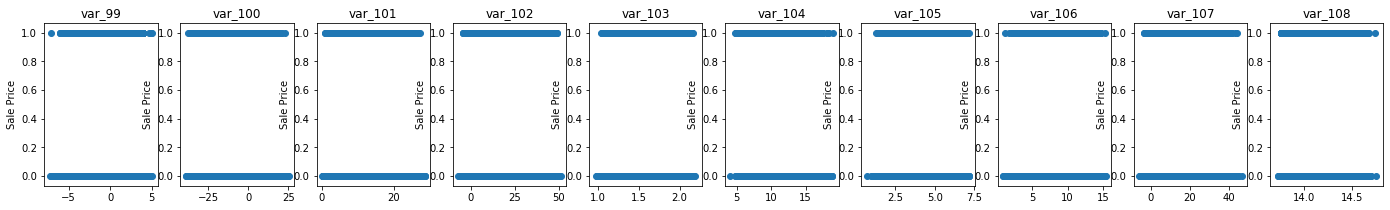

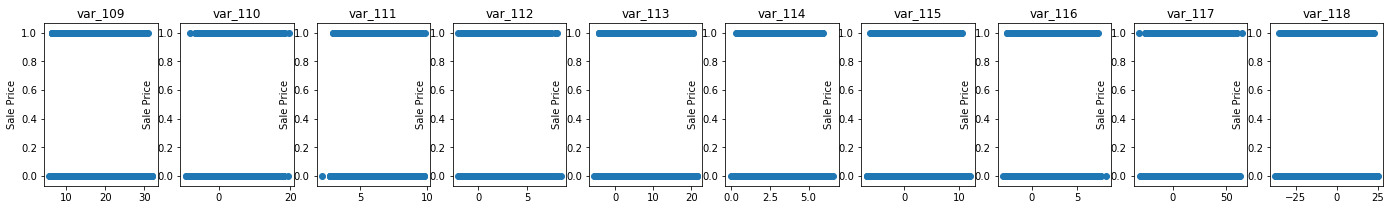

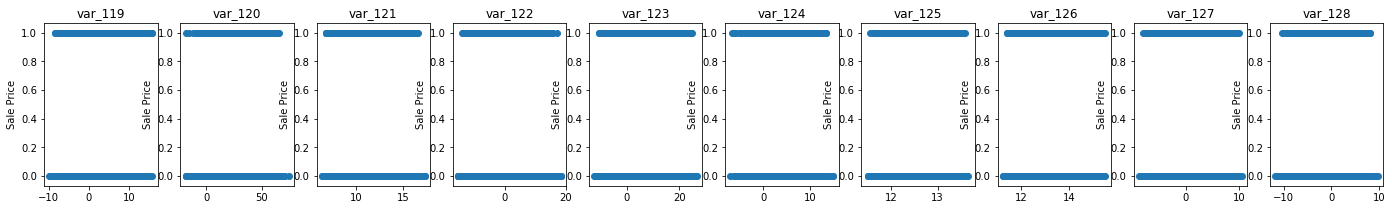

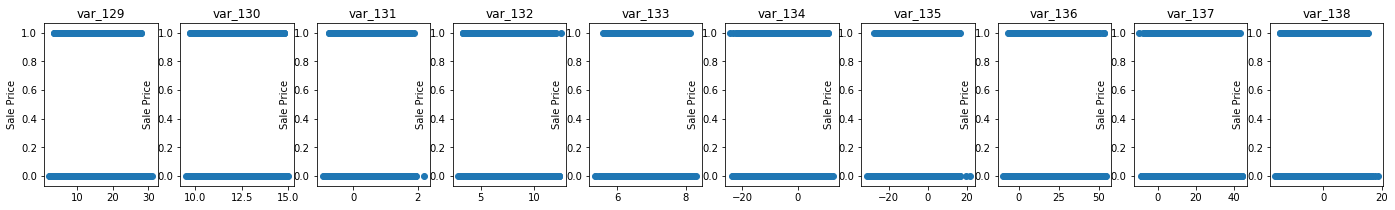

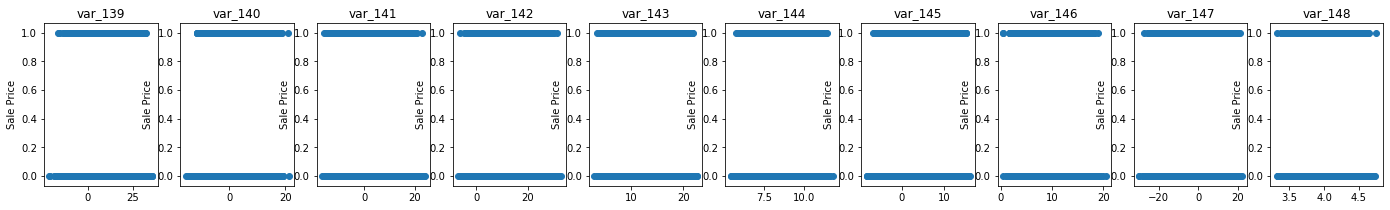

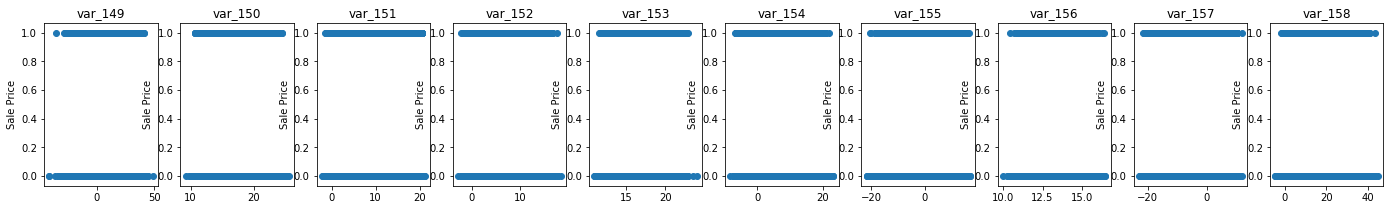

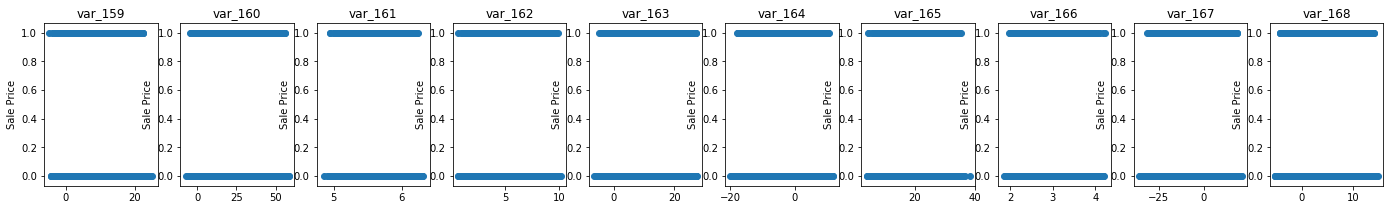

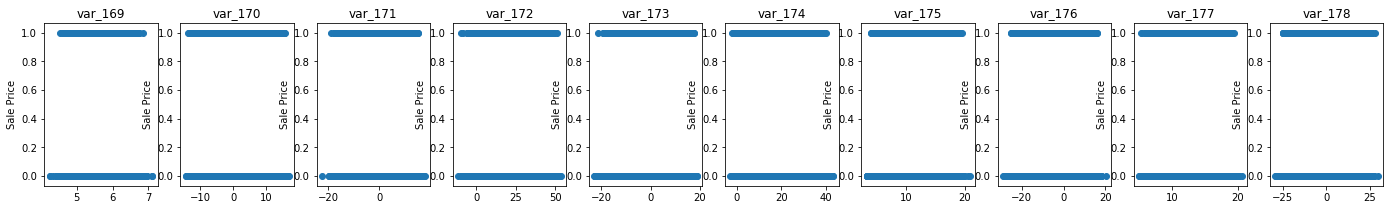

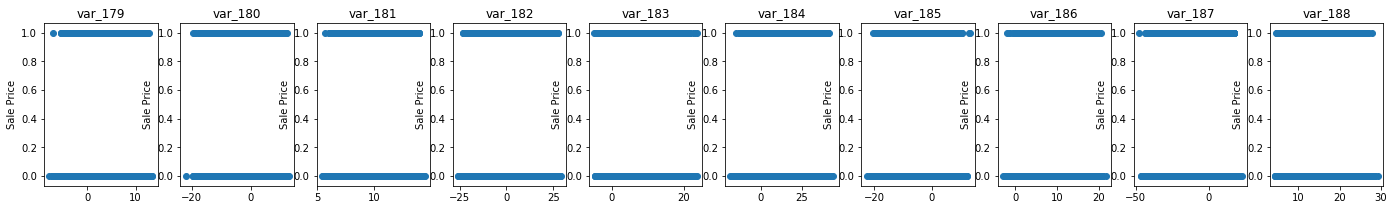

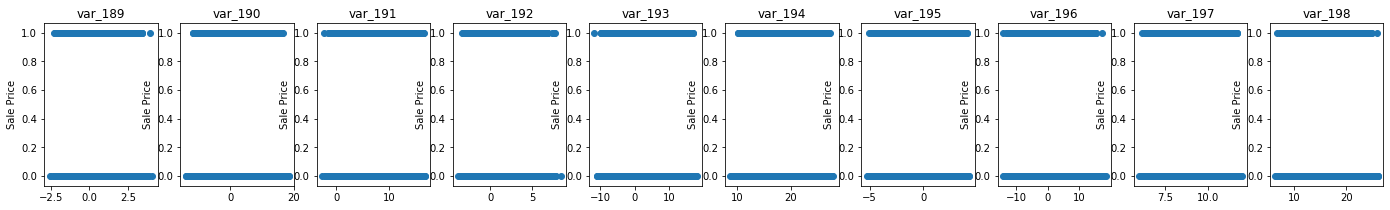

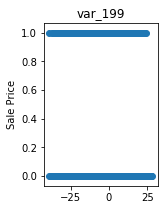

In [20]:
variables = ['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11',
       'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17',
       'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23',
       'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29',
       'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35',
       'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41',
       'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47',
       'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53',
       'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59',
       'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65',
       'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71',
       'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77',
       'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83',
       'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89',
       'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95',
       'var_96', 'var_97', 'var_98', 'var_99', 'var_100', 'var_101',
       'var_102', 'var_103', 'var_104', 'var_105', 'var_106', 'var_107',
       'var_108', 'var_109', 'var_110', 'var_111', 'var_112', 'var_113',
       'var_114', 'var_115', 'var_116', 'var_117', 'var_118', 'var_119',
       'var_120', 'var_121', 'var_122', 'var_123', 'var_124', 'var_125',
       'var_126', 'var_127', 'var_128', 'var_129', 'var_130', 'var_131',
       'var_132', 'var_133', 'var_134', 'var_135', 'var_136', 'var_137',
       'var_138', 'var_139', 'var_140', 'var_141', 'var_142', 'var_143',
       'var_144', 'var_145', 'var_146', 'var_147', 'var_148', 'var_149',
       'var_150', 'var_151', 'var_152', 'var_153', 'var_154', 'var_155',
       'var_156', 'var_157', 'var_158', 'var_159', 'var_160', 'var_161',
       'var_162', 'var_163', 'var_164', 'var_165', 'var_166', 'var_167',
       'var_168', 'var_169', 'var_170', 'var_171', 'var_172', 'var_173',
       'var_174', 'var_175', 'var_176', 'var_177', 'var_178', 'var_179',
       'var_180', 'var_181', 'var_182', 'var_183', 'var_184', 'var_185',
       'var_186', 'var_187', 'var_188', 'var_189', 'var_190', 'var_191',
       'var_192', 'var_193', 'var_194', 'var_195', 'var_196', 'var_197',
       'var_198', 'var_199']
count = 0
for x in variables:
    plt.figure(count//10,figsize=(24,3))
    plt.subplot(1,10,np.mod(count,10)+1)
    plt.scatter(traindf[x], y_train)
    plt.title(label=x)
    plt.ylabel('Sale Price')
    count += 1
plt.show() 

In [21]:
correlation=pd.DataFrame(traindf.corr()["target"]) 
correlation

,target
target,1.000000
var_0,0.052390
var_1,0.050343
var_2,0.055870
var_3,0.011055
...,...
var_195,0.028285
var_196,0.023608
var_197,-0.035303
var_198,-0.053000


##### Covariance Matrix:

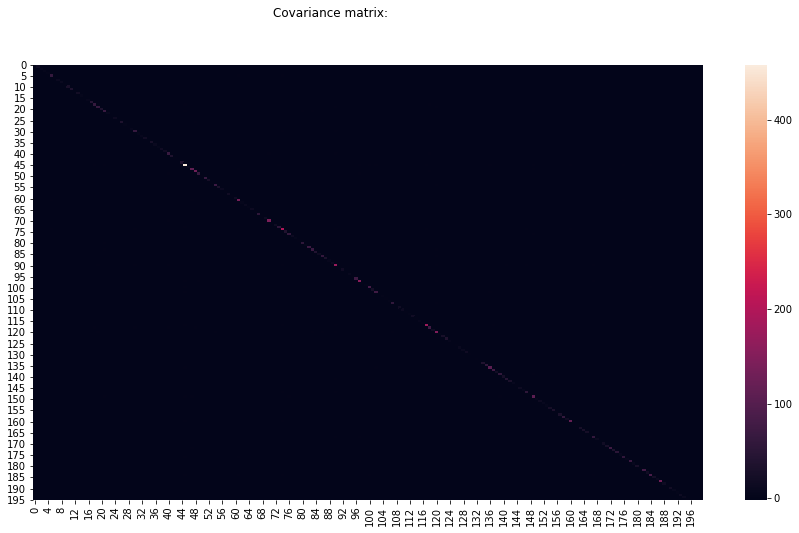

In [22]:
cov = np.cov(traindf.loc[:, 'var_0':'var_199'], rowvar=False)
plt.figure(figsize=(15, 8))
sns.heatmap(cov)
plt.suptitle('Covariance matrix:', x=0.4)
plt.show()

##### Mean and std distributions:

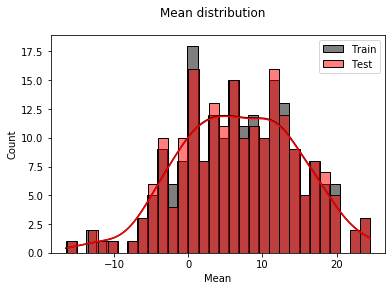

In [23]:
sns.histplot(traindf.loc[:, 'var_0':'var_199'].mean(axis=0), bins=30, kde=True, label='Train', color='black', alpha=0.5)
sns.histplot(testdf.loc[:, 'var_0':'var_199'].mean(axis=0), bins=30, kde=True, label='Test', color='red', alpha=0.5)
plt.xlabel('Mean')
plt.legend()
plt.suptitle('Mean distribution');

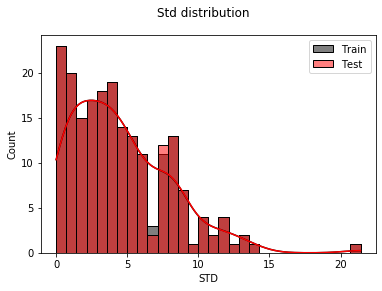

In [24]:
sns.histplot(traindf.loc[:, 'var_0':'var_199'].std(axis=0), bins=30, kde=True, label='Train', color='black', alpha=0.5)
sns.histplot(testdf.loc[:, 'var_0':'var_199'].std(axis=0), bins=30, kde=True, label='Test', color='red', alpha=0.5)
plt.xlabel('STD')
plt.legend()
plt.suptitle('Std distribution');

##### Check for normality:

For 'variables_normal' we manually view certain variables to check that they follow a normal distribution, we can not output every variable at once because of memory.

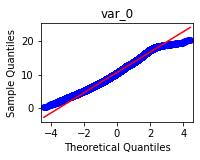

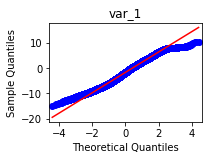

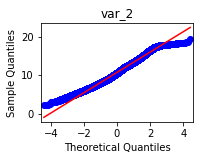

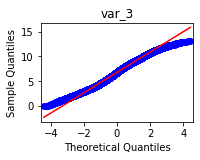

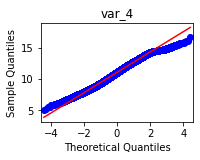

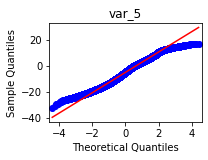

In [25]:
variables_normal = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5']

for x in variables_normal:
    qqplot(traindf[x], line='s', ax = plt.subplot(222))
    plt.title(label=x)
    plt.show() 

## Prepare for modeling

Build the Linear Regression model for quick statistics.

In [26]:
trainstats = traindf.copy()
teststats = testdf.copy()

ids = testdf['ID_code']

In [27]:
trainstats.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


In [28]:
xstats = trainstats.drop(['target','ID_code'], axis = 1).values
ystats = trainstats.loc[:,'target'].values

In [29]:
x1 = sm.add_constant(xstats)
results = sm.OLS(ystats,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     221.9
Date:                Tue, 02 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:27:38   Log-Likelihood:                -23370.
No. Observations:              200000   AIC:                         4.714e+04
Df Residuals:                  199799   BIC:                         4.919e+04
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9416      0.437     11.315      0.000       4.086       5.798
x1             0.0042      0.000     21.048      0.000       0.004       0.005
x2             0.0031      0.000     20.382      0.000       0.003       0.003
x3             0.0052      0.000     22.539      0.000       0.005       0.006
x4             0.0014      0.000      4.674      0.000       0.001       0.002
x5             0.0019      0.000      5.129      0.000       0.001       0.003
x6             0.0010   7.74e-05     13.320      0.000       0.001       0.001
x7             0.0193      0.001     27.405      0.000       0.018       0.021
x8            -0.0001      0.000     -0.736      0.462      -0.000       0.000
x9             0.0013      0.000      7.357      0.000       0.001       0.002
x10           -0.0084      0.000    -17.029      0.000      -0.009      -0.007
x11        -7.504e-05      0.000     -0.678      0.498      -0.000       0.000
x12            0.0009      0.000      8.880      0.000       0.001       0.001
x13           -0.0890      0.003    -27.777      0.000      -0.095      -0.083
x14           -0.0030      0.000    -22.715      0.000      -0.003      -0.003
x15           -0.0006      0.000     -2.181      0.029      -0.001   -5.99e-05
x16            0.0110      0.001      7.437      0.000       0.008       0.014
x17            0.0007      0.000      2.980      0.003       0.000       0.001
x18        -2.135e-05   9.07e-05     -0.235      0.814      -0.000       0.000
x19            0.0013   7.75e-05     17.115      0.000       0.001       0.001
x20            0.0003   7.61e-05      4.161      0.000       0.000       0.000
x21           -0.0008      0.000     -7.824      0.000      -0.001      -0.001
x22           -0.0018   7.43e-05    -23.987      0.000      -0.002      -0.002
x23            0.0054      0.000     25.063      0.000       0.005       0.006
x24           -0.0125      0.001    -10.789      0.000      -0.015      -0.010
x25            0.0020      0.000     12.261      0.000       0.002       0.002
x26            0.0101      0.002      4.738      0.000       0.006       0.014
x27            0.0026      0.000     25.226      0.000       0.002       0.003
x28           -0.0002      0.000     -0.602      0.547      -0.001       0.001
x29           -0.0077      0.001     -9.902      0.000      -0.009      -0.006
x30            0.0006      0.000      2.756      0.006       0.000       0.001
x31        -1.999e-05   7.64e-05     -0.262      0.794      -0.000       0.000
x32           -0.0030      0.000    -10.649      0.000      -0.004      -0.002
x33            0.0029      0.000     12.163      0.000       0.002       0.003
x34           -0.0027      0.000    -18.895      0.000      -0.003      -0.002
x35           -0.0241      0.001    -21.391      0.000      -0.026      -0.022
x3

##### The linear model is a great way to individually look at all our variables and their corespondance to our constant

In [30]:
Y = y_train
X = traindf.drop(['ID_code','target'], axis=1)
X_test = testdf.drop('ID_code', axis=1)

In [31]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, random_state=1, test_size=0.25)

In [32]:
with parallel_backend('threading', n_jobs=-1):
    rfc_model = RandomForestClassifier(random_state=0).fit(train_x, train_y)
    perm = PermutationImportance(rfc_model, random_state=1).fit(val_x, val_y)

In [33]:
eli5.show_weights(perm, feature_names = val_x.columns.tolist(), top=200)

Weight,Feature
0.0000 ± 0.0000,var_99
0.0000 ± 0.0000,var_174
0.0000 ± 0.0000,var_184
0.0000 ± 0.0000,var_166
0.0000 ± 0.0000,var_154
0.0000 ± 0.0000,var_12
0.0000 ± 0.0000,var_133
0.0000 ± 0.0000,var_145
0.0000 ± 0.0000,var_1
0.0000 ± 0.0000,var_139


## Model building

##### Validate our training set

In [34]:
def training_predictor(ml):          
    model = ml.fit(train_x,train_y)
    print('Score : {}'.format(model.score(train_x,train_y)))

In [35]:
with parallel_backend('threading', n_jobs=-1):
    training_predictor(LinearRegression())

Score : 0.1829733448589257


In [36]:
with parallel_backend('threading', n_jobs=-1):
    training_predictor(KNeighborsClassifier(n_neighbors = 2, n_jobs=-1, metric = 'minkowski', p = 2))

Score : 0.90556


In [37]:
with parallel_backend('threading', n_jobs=-1):
    training_predictor(DecisionTreeClassifier(criterion = 'entropy',max_depth=11, random_state = 0))

Score : 0.9142866666666667


In [38]:
with parallel_backend('threading', n_jobs=-1):
    training_predictor(CatBoostClassifier(iterations=3500, learning_rate=.1, eval_metric='AUC', verbose=False))

Score : 0.9888066666666666


In [39]:
#Y = y_train
#X = traindf.drop(['ID_code','target'], axis=1)
#X_test = testdf.drop('ID_code', axis=1)

## Final model build

In [40]:
def predictor(ml):          
    model = ml.fit(X,Y)
    print('Score : {}'.format(model.score(X,Y)))
    global y_pred
    y_pred = model.predict(X_test)

In [41]:
with parallel_backend('threading', n_jobs=-1):
    predictor(LinearRegression())

Score : 0.18173779218011887


##### KNeighbors Classifier:

In [42]:
with parallel_backend('threading', n_jobs=-1):
    predictor(KNeighborsClassifier(n_neighbors = 2, n_jobs=-1, metric = 'minkowski', p = 2))
    KNC = y_pred
KNC

Score : 0.906155


array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

##### Decision Tree Classifier:

In [43]:
with parallel_backend('threading', n_jobs=-1):
    predictor(DecisionTreeClassifier(criterion = 'entropy',max_depth=5, random_state = 0))
    DTC = y_pred
DTC

Score : 0.90004


array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

##### CatBoost Classifier

In [44]:
with parallel_backend('threading', n_jobs=-1):
    predictor(CatBoostClassifier(iterations=3500, learning_rate=.1, eval_metric='AUC', verbose=False))
    CBC = y_pred
CBC

Score : 0.98024


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Submit work

Combine models.

In [ ]:
all_models = mode([CBC,DTC,KNC])
final_pred = list(all_models.mode[0])

In [ ]:
submission = pd.DataFrame({
        "ID_code": ids,
        "target": all_models
    })
submission.head()
submission.style.hide_index()

In [ ]:
submission.to_csv('santander_submission.csv', index=False)

Sources:

https://www.kaggle.com/jamesngoa/eda-customer-transaction/comments

https://www.kaggle.com/mjbahmani/santander-ml-explainability/comments#6--Model-Development